In [1]:
!wget http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes -O mm10.chrom.sizes 

--2020-06-13 00:19:10--  http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1405 (1.4K) [text/plain]
Saving to: ‘mm10.chrom.sizes’

mm10.chrom.sizes    100%[===================>]   1.37K  --.-KB/s    in 0s      

2020-06-13 00:19:10 (96.4 MB/s) - ‘mm10.chrom.sizes’ saved [1405/1405]



In [2]:
#get 1kb around summits
!zcat Oct4/idr-optimal-set.summit.bed.gz Sox2/idr-optimal-set.summit.bed.gz Nanog/idr-optimal-set.summit.bed.gz Klf4/idr-optimal-set.summit.bed.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g mm10.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > 1k_around_summits.bed.gz
#split into train, valid, test sets
!zcat 1k_around_summits.bed.gz | egrep -w 'chr2|chr3|chr4' | gzip -c > test_1k_around_summits.bed.gz
!zcat 1k_around_summits.bed.gz | egrep -w 'chr1|chr8|chr9' | gzip -c > valid_1k_around_summits.bed.gz
!zcat 1k_around_summits.bed.gz | egrep -w -v 'chr1|chr2|chr3|chr4|chr9' | gzip -c > train_1k_around_summits.bed.gz

In [3]:
from collections import OrderedDict
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from seqdataloader.batchproducers.coordbased.coordstovals.core import CoordsToValsJoiner
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import AbstractCountAndProfileTransformer 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import LogCountsPlusOne
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import SmoothProfiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import BigWigReader 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import smooth_profiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import rolling_window
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import MultiTrackCountsAndProfile
import keras
import keras.layers as kl
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers.coordbased.core import Coordinates, KerasBatchGenerator, apply_mask
from keras.models import load_model
import os
from keras.utils import CustomObjectScope
from seqdataloader.batchproducers.coordbased.core import Coordinates

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#Written by Žiga Avsec
import pyBigWig

#loss function
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#Written by Žiga Avsec
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}
    
#poisson loss but we take the exponent of the
# labels to convert them from log(counts+1)
# to counts.
def exponentiate_label_poisson(true, preds):
    true_counts = tf.exp(true)-1
    return tf.keras.losses.poisson(y_true=true_counts,
                                   y_pred=preds)


def poisson_loglinear_loss(true, preds):
    true_counts = tf.exp(true)-1
    preds_counts = tf.exp(preds)
    return tf.keras.losses.poisson(y_true=true_counts,
                                   y_pred=preds_counts)

In [7]:
# If we want to avoid zero-padding, then the size of the output predictions
# will depend on the size of the input sequence supplied. We define the
# API for an AbstractProfileModel class which returns the length of the
# output profile in addition to returning the model, given information
# on the size of the input sequence and the model parameters.
        
class AbstractProfileModel(object):
    
    def get_output_profile_len(self):
        raise NotImplementedError()
  
    def get_model(self):
        raise NotImplementedError()

# The architecture by Žiga Avsec involves residual connections, which means
# that the layers being added together in an elementwise fashion need
# to have the same dimensions. To achieve this without zero-padding, we
# have to trim away the flanks of earlier convolutional layers. That
# is what this function is meant to do. (Note that the original BP-net
# architecture zero-pads; this is a modification to avoid the zero
# padding and use information on actual sequence instead)

def trim_flanks_of_conv_layer(conv_layer, output_len, width_to_trim, filters):
    layer = keras.layers.Lambda(
        lambda x: x[:,
          int(0.5*(width_to_trim)):-(width_to_trim-int(0.5*(width_to_trim)))],
        output_shape=(output_len, filters))(conv_layer)
    return layer


#This model architecture is based on BP-Net by Žiga Avsec
# https://drive.google.com/file/d/1kg6Ic0-FvJtVUva9Mh3FPnOAHJcN6VB-/view
#It has been modified for this specific use-case.
class BPnetArch(AbstractProfileModel):   

    def __init__(self, counts_loss,
                       log_space_preds,
                       counts_hiddenlayer_size,
                       input_seq_len, c_task_weight, filters,
                       n_dil_layers, conv1_kernel_size,
                       dil_kernel_size,
                       outconv_kernel_size, lr,
                       seed=1234):
        self.counts_loss = counts_loss
        self.log_space_preds = log_space_preds
        print("LOG SPACE PREDS IS SET TO",log_space_preds)
        self.counts_hiddenlayer_size = counts_hiddenlayer_size
        self.input_seq_len = input_seq_len
        self.c_task_weight = c_task_weight
        self.filters = filters
        self.n_dil_layers = n_dil_layers
        self.conv1_kernel_size = conv1_kernel_size
        self.dil_kernel_size = dil_kernel_size
        self.outconv_kernel_size = outconv_kernel_size
        self.lr = lr
        self.seed = seed
    
    def get_embedding_len(self):
        embedding_len = self.input_seq_len
        embedding_len -= (self.conv1_kernel_size-1)     
        for i in range(1, self.n_dil_layers+1):
            dilation_rate = (2**i)
            embedding_len -= dilation_rate*(self.dil_kernel_size-1)
        return embedding_len
    
    def get_output_profile_len(self):
        embedding_len = self.get_embedding_len()
        out_profile_len = embedding_len - (self.outconv_kernel_size - 1)
        return out_profile_len
    
    def get_keras_model(self):
      
        np.random.seed(self.seed)
        tf.set_random_seed(self.seed)

        out_pred_len = self.get_output_profile_len()
        
        #'inp' is the one-hot encoded DNA sequence input
        inp = kl.Input(shape=(self.input_seq_len, 4), name='sequence')
        first_conv = kl.Conv1D(filters=self.filters,
                               kernel_size=self.conv1_kernel_size,
                               padding='valid',
                               activation='relu')(inp)
        
        #Need to keep track of the layer size for trimming purposes when
        # we get to the residual connections.
        
        curr_layer_size = self.input_seq_len - (self.conv1_kernel_size-1)
        
        #Define input layers for the control tracks - both counts and profile
        #Dimension is '1' for the ChIP-seq control counts because the positive
        # and negative strands are added together
        
        patchcap_logcount = kl.Input(
            shape=(2,), name="patchcap.logcount")
        #if working with raw counts, go from logcount->count
        if (self.log_space_preds==False):
            patchcap_count_touse = kl.Lambda(lambda x: tf.exp(x)-1)(patchcap_logcount) 
        else:
            patchcap_count_touse = patchcap_logcount
        
        patchcap_profile = kl.Input(
            shape=(out_pred_len, 2), name="patchcap.profile")
        
        #Gather together all the tensors representing the model inputs
        model_inputs = [
            inp,
            patchcap_logcount,
            patchcap_profile
        ]
        
        #Prepare the stack of dilated convolutions with residual connections
        prev_layer = first_conv
        for i in range(1, self.n_dil_layers + 1):
            dilation_rate = 2**i
            conv_output = kl.Conv1D(filters=self.filters,
                                  kernel_size=self.dil_kernel_size,
                                  padding='valid',
                                  activation='relu',
                                  dilation_rate=dilation_rate)(prev_layer)          
            width_to_trim = dilation_rate*(self.dil_kernel_size-1)
            curr_layer_size = (curr_layer_size - width_to_trim)
            prev_layer = trim_flanks_of_conv_layer(
              conv_layer=prev_layer, output_len=curr_layer_size,
              width_to_trim=width_to_trim, filters=self.filters)
            prev_layer = kl.merge.Add()([prev_layer, conv_output])

        combined_conv = prev_layer

        #gap = GlobalAveragePooling. This layer is used as input for the
        # counts prediction tasks.
        gap_combined_conv = kl.GlobalAvgPool1D()(combined_conv)
        
        lossarr = []
        lossweightsarr = []
        model_outputs = []
    
        #Define the output layers for the counts prediction tasks
        for countouttaskname, numunits, countcontrolinp in [("CHIPNexus.NANOG.logcount", 2, patchcap_count_touse),
                                                            ("CHIPNexus.OCT4.logcount", 2, patchcap_count_touse),
                                                            ("CHIPNexus.KLF4.logcount", 2, patchcap_count_touse),
                                                            ("CHIPNexus.SOX2.logcount", 2, patchcap_count_touse)]:
            precount_out = kl.concatenate([gap_combined_conv,
                                           countcontrolinp], axis=-1)
            if (self.counts_hiddenlayer_size is not None):
                precount_out = kl.Dense(
                    units=self.counts_hiddenlayer_size,
                    activation="relu")(precount_out)
            count_out = kl.Dense(
                units=numunits,
                name=countouttaskname,
                activation=("linear" if self.log_space_preds else "softplus"))(
                    precount_out)
            model_outputs.append(count_out)
            lossarr.append(self.counts_loss)
            lossweightsarr.append(self.c_task_weight)

        #Define the output layers for the profile prediction tasks
        for profileouttaskname, numunits, profilecontrolinp in [("CHIPNexus.NANOG.profile", 2, patchcap_profile),
                                                                ("CHIPNexus.OCT4.profile", 2, patchcap_profile),
                                                                ("CHIPNexus.KLF4.profile", 2, patchcap_profile),
                                                                ("CHIPNexus.SOX2.profile", 2, patchcap_profile)]:
                                                                
        
            profile_out_precontrol = kl.Conv1D(
                                      filters=numunits,
                                      kernel_size=self.outconv_kernel_size,
                                      padding='valid')(combined_conv)
            profile_out = kl.Conv1D(filters=numunits, kernel_size=1, name=profileouttaskname)(kl.concatenate([profile_out_precontrol,profilecontrolinp], axis=-1))

            model_outputs.append(profile_out)
            lossarr.append(MultichannelMultinomialNLL(numunits)) 
              #We downweight the loss by the number of channels because, if you
              # read the code for MultichannelMultinomialNLL, you'll see that
              # the loss for different channels is added together;
              # but I (Avanti Shrikumar) didn't want to implicitly upweight
              # the prediction tasks that happen
              # to have more channels, hence this downweighting.
            lossweightsarr.append(1.0/numunits)

        #Compile the model and return it
        model = keras.models.Model(inputs=model_inputs, outputs=model_outputs)
        model.compile(keras.optimizers.Adam(lr=self.lr),
                      loss=lossarr,
                      loss_weights=lossweightsarr)
        return model

seq_len = 1346
out_pred_len = 1000
#out_pred_len = modelwrapper.get_output_profile_len()
#print(out_pred_len, seq_len-out_pred_len)   
    
    
# the code below is used to prepare instances of keras.utils.Sequence that
# can be supplied to model.fit_generator(...)
# Note that we log-transform our counts using np.log(counts+1)
# Also note that the profiles for the control are smoothed by windows of
# size 1 and 50 (smoothing by a window of size 1 just returns
# the original profile)

inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="mm10_no_alt_analysis_set_ENCODE.fasta",
        mode_name="sequence",
        center_size_to_use=seq_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="patchcap.logcount",
        profile_mode_name="patchcap.profile",
        pos_strand_bigwig_path="patchcap/counts.pos.bw",
        neg_strand_bigwig_path="patchcap/counts.neg.bw",
        center_size_to_use=out_pred_len),
    ]
)
    

targets_coordstovals = CoordsToValsJoiner(
    coordstovals_list=[
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.NANOG.logcount",
        profile_mode_name="CHIPNexus.NANOG.profile",
        pos_strand_bigwig_path="Nanog/counts.pos.bw",
        neg_strand_bigwig_path="Nanog/counts.neg.bw",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.OCT4.logcount",
        profile_mode_name="CHIPNexus.OCT4.profile",
        pos_strand_bigwig_path="Oct4/counts.pos.bw",
        neg_strand_bigwig_path="Oct4/counts.neg.bw",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.KLF4.logcount",
        profile_mode_name="CHIPNexus.KLF4.profile",
        pos_strand_bigwig_path="Klf4/counts.pos.bw",
        neg_strand_bigwig_path="Klf4/counts.neg.bw",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.SOX2.logcount",
        profile_mode_name="CHIPNexus.SOX2.profile",
        pos_strand_bigwig_path="Sox2/counts.pos.bw",
        neg_strand_bigwig_path="Sox2/counts.neg.bw",
        center_size_to_use=out_pred_len),
    ]
)

keras_train_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="train_1k_around_summits.bed.gz",
      batch_size=64,
      shuffle_before_epoch=True, 
      seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals,
  coordsbatch_transformer=
          coordbatchtransformers.ReverseComplementAugmenter().chain(
          coordbatchtransformers.UniformJitter(
              maxshift=200, chromsizes_file="mm10.chrom.sizes")),
)

keras_valid_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="valid_1k_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals
)

#As a sanity check, print out the dimensions of everything in individual batches
sampinputs,samptargets = keras_train_batch_generator[0]
# for key in sampinputs:
#   print(key, sampinputs[key].shape)
for key in samptargets:
    print(key, samptargets[key].shape)

LOG SPACE PREDS IS SET TO True
1000 346
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
CHIPNexus.NANOG.logcount (128, 2)
CHIPNexus.NANOG.profile (128, 1000, 2)
CHIPNexus.OCT4.logcount (128, 2)
CHIPNexus.OCT4.profile (128, 1000, 2)
CHIPNexus.KLF4.logcount (128, 2)
CHIPNexus.KLF4.profile (128, 1000, 2)
CHIPNexus.SOX2.logcount (128, 2)
CHIPNexus.SOX2.profile (128, 1000, 2)


In [8]:
def extend_generator(generator):
    samp_inputs, samp_targets = generator[0]
    concat_inputs = OrderedDict([(key, []) for key in samp_inputs.keys()])
    concat_targets = OrderedDict([(key, []) for key in samp_targets.keys()])

    for batch_idx in range(len(generator)):
        batch_inputs, batch_targets = generator[batch_idx]
        for key in batch_inputs:
            concat_inputs[key].extend(batch_inputs[key])
        for key in batch_targets:
            concat_targets[key].extend(batch_targets[key])
    
    for key in concat_inputs:
        concat_inputs[key] = np.array(concat_inputs[key])
    
    for key in concat_targets:
        concat_targets[key] = np.array(concat_targets[key])
    
    return (concat_inputs, concat_targets)

from scipy.stats import spearmanr
from matplotlib import pyplot as plt

def plot_scatter(preds, targets, keys, takelogofpreds):
    fig, ax = plt.subplots(nrows=1, ncols=len(keys),
                           figsize=(5*len(keys),5))
    for i,key in enumerate(keys):
        if takelogofpreds:
            x = np.sum(np.log(preds[key]+1), axis=-1)
        else:
            x = np.sum(preds[key], axis=-1)
        y = np.sum(targets[key], axis=-1)
        ax[i].scatter(x, y, alpha=0.01)        
        ax[i].set_xlabel("Preds: "+key)
        ax[i].set_ylabel("Targets: "+key)
        ax[i].plot(x, x, color='black')
        print(key,spearmanr(x,y))
    plt.show()

In [9]:
#get the unrolled validation set
valid_concat_inputs, valid_concat_targets = extend_generator(keras_valid_batch_generator)

LOG SPACE PREDS IS SET TO True
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 1326, 64)     5440        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 1322, 64)     0           conv1d_12[0][0]                  
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 1322, 64)     12352       conv1d_12[0][0]                  
_____________________________________________________________

Epoch 1/200
Scatterplots before epoch 0
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=-0.18356259101686823, pvalue=1.1503648010993944e-208)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.34400206556951973, pvalue=0.0)
CHIPNexus.NANOG.logcount SpearmanrResult(correlation=0.07072395145507282, pvalue=4.354816961994041e-32)
CHIPNexus.KLF4.logcount SpearmanrResult(correlation=0.14687417647117695, pvalue=1.6565222315819852e-133)


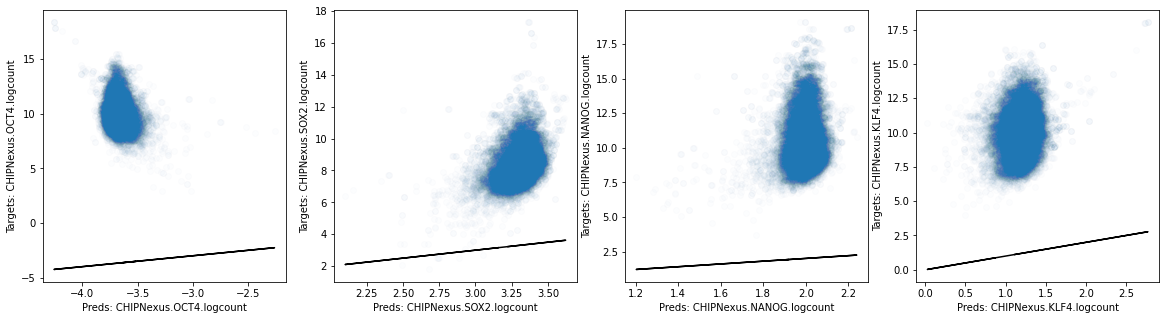

1614/1614 [==============================] - 721s 447ms/step - loss: 3253.1512 - CHIPNexus.NANOG.logcount_loss: 0.8540 - CHIPNexus.OCT4.logcount_loss: 0.5080 - CHIPNexus.KLF4.logcount_loss: 0.5827 - CHIPNexus.SOX2.logcount_loss: 0.3201 - CHIPNexus.NANOG.profile_loss: 1349.5853 - CHIPNexus.OCT4.profile_loss: 1098.3854 - CHIPNexus.KLF4.profile_loss: 1147.2266 - CHIPNexus.SOX2.profile_loss: 646.2821 - val_loss: 2276.8750 - val_CHIPNexus.NANOG.logcount_loss: 0.8186 - val_CHIPNexus.OCT4.logcount_loss: 0.3761 - val_CHIPNexus.KLF4.logcount_loss: 0.5303 - val_CHIPNexus.SOX2.logcount_loss: 0.2703 - val_CHIPNexus.NANOG.profile_loss: 1331.3613 - val_CHIPNexus.OCT4.profile_loss: 963.7234 - val_CHIPNexus.KLF4.profile_loss: 1052.4379 - val_CHIPNexus.SOX2.profile_loss: 559.3782
Epoch 2/200
Scatterplots before epoch 1
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.34858555359213195, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.39002405591082145, pvalue=0.0)
CHIPNexus.NANOG.

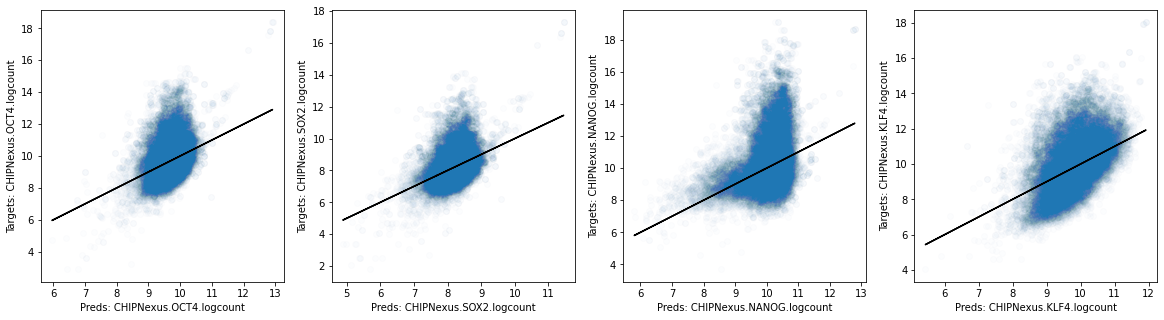

1614/1614 [==============================] - 727s 450ms/step - loss: 2948.6599 - CHIPNexus.NANOG.logcount_loss: 0.7663 - CHIPNexus.OCT4.logcount_loss: 0.3894 - CHIPNexus.KLF4.logcount_loss: 0.5069 - CHIPNexus.SOX2.logcount_loss: 0.2746 - CHIPNexus.NANOG.profile_loss: 1224.5972 - CHIPNexus.OCT4.profile_loss: 1025.4077 - CHIPNexus.KLF4.profile_loss: 1091.2463 - CHIPNexus.SOX2.profile_loss: 618.8328 - val_loss: 1992.2540 - val_CHIPNexus.NANOG.logcount_loss: 0.6968 - val_CHIPNexus.OCT4.logcount_loss: 0.3332 - val_CHIPNexus.KLF4.logcount_loss: 0.4997 - val_CHIPNexus.SOX2.logcount_loss: 0.2483 - val_CHIPNexus.NANOG.profile_loss: 1262.4901 - val_CHIPNexus.OCT4.profile_loss: 930.0494 - val_CHIPNexus.KLF4.profile_loss: 1012.6890 - val_CHIPNexus.SOX2.profile_loss: 547.0754
Epoch 3/200
Scatterplots before epoch 2
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.47384387184101096, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.4923056432662813, pvalue=0.0)
CHIPNexus.NANOG.l

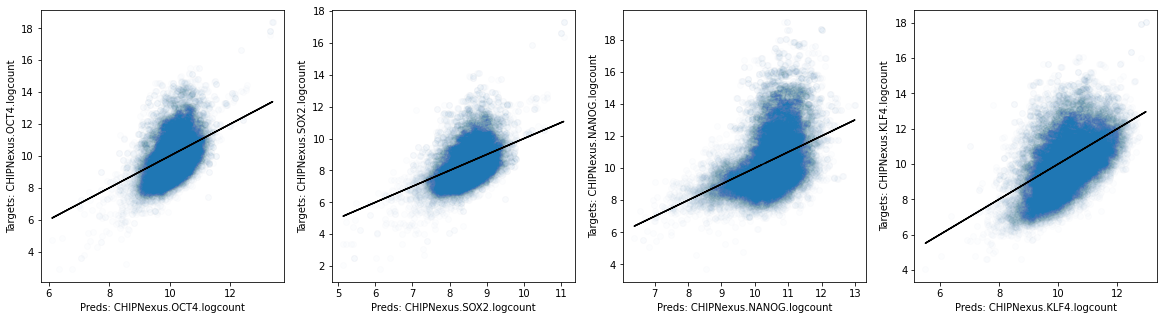

1614/1614 [==============================] - 726s 450ms/step - loss: 2786.9682 - CHIPNexus.NANOG.logcount_loss: 0.7123 - CHIPNexus.OCT4.logcount_loss: 0.3348 - CHIPNexus.KLF4.logcount_loss: 0.4847 - CHIPNexus.SOX2.logcount_loss: 0.2416 - CHIPNexus.NANOG.profile_loss: 1180.8458 - CHIPNexus.OCT4.profile_loss: 965.9452 - CHIPNexus.KLF4.profile_loss: 1055.9238 - CHIPNexus.SOX2.profile_loss: 597.7698 - val_loss: 1920.5081 - val_CHIPNexus.NANOG.logcount_loss: 0.7582 - val_CHIPNexus.OCT4.logcount_loss: 0.3014 - val_CHIPNexus.KLF4.logcount_loss: 0.4743 - val_CHIPNexus.SOX2.logcount_loss: 0.2422 - val_CHIPNexus.NANOG.profile_loss: 1237.7139 - val_CHIPNexus.OCT4.profile_loss: 912.7374 - val_CHIPNexus.KLF4.profile_loss: 1015.9886 - val_CHIPNexus.SOX2.profile_loss: 539.1440
Epoch 4/200
Scatterplots before epoch 3
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5394397923931322, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.54558945356536, pvalue=0.0)
CHIPNexus.NANOG.logco

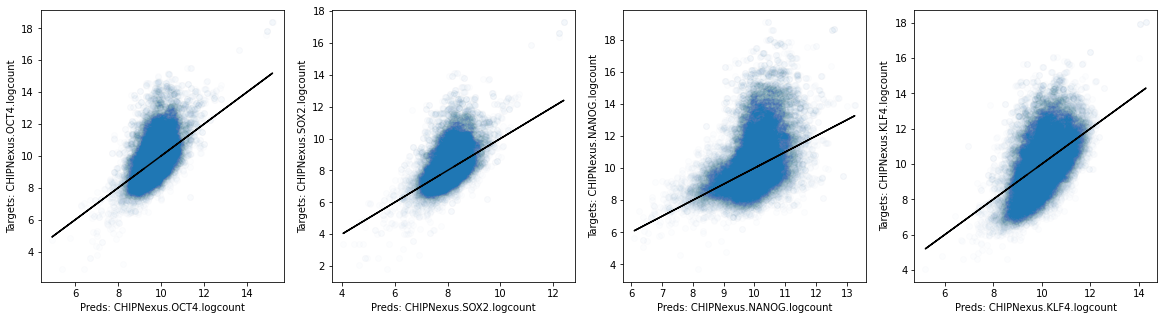

1614/1614 [==============================] - 744s 461ms/step - loss: 2658.9894 - CHIPNexus.NANOG.logcount_loss: 0.6750 - CHIPNexus.OCT4.logcount_loss: 0.3068 - CHIPNexus.KLF4.logcount_loss: 0.4638 - CHIPNexus.SOX2.logcount_loss: 0.2201 - CHIPNexus.NANOG.profile_loss: 1147.2499 - CHIPNexus.OCT4.profile_loss: 908.1543 - CHIPNexus.KLF4.profile_loss: 1020.0737 - CHIPNexus.SOX2.profile_loss: 576.8137 - val_loss: 2150.1279 - val_CHIPNexus.NANOG.logcount_loss: 0.7089 - val_CHIPNexus.OCT4.logcount_loss: 0.2875 - val_CHIPNexus.KLF4.logcount_loss: 0.4544 - val_CHIPNexus.SOX2.logcount_loss: 0.2116 - val_CHIPNexus.NANOG.profile_loss: 1219.5953 - val_CHIPNexus.OCT4.profile_loss: 911.2866 - val_CHIPNexus.KLF4.profile_loss: 1038.7797 - val_CHIPNexus.SOX2.profile_loss: 540.5972
Epoch 5/200
Scatterplots before epoch 4
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5465575967057812, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.586813745237597, pvalue=0.0)
CHIPNexus.NANOG.logc

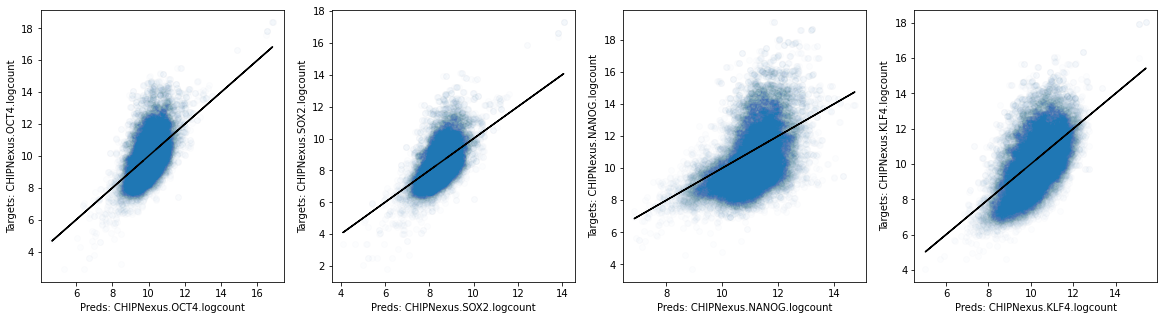

1614/1614 [==============================] - 721s 447ms/step - loss: 2572.0084 - CHIPNexus.NANOG.logcount_loss: 0.6503 - CHIPNexus.OCT4.logcount_loss: 0.2973 - CHIPNexus.KLF4.logcount_loss: 0.4491 - CHIPNexus.SOX2.logcount_loss: 0.2110 - CHIPNexus.NANOG.profile_loss: 1125.8873 - CHIPNexus.OCT4.profile_loss: 865.5651 - CHIPNexus.KLF4.profile_loss: 993.4922 - CHIPNexus.SOX2.profile_loss: 551.2932 - val_loss: 1948.9650 - val_CHIPNexus.NANOG.logcount_loss: 0.6079 - val_CHIPNexus.OCT4.logcount_loss: 0.2604 - val_CHIPNexus.KLF4.logcount_loss: 0.4532 - val_CHIPNexus.SOX2.logcount_loss: 0.2050 - val_CHIPNexus.NANOG.profile_loss: 1171.7820 - val_CHIPNexus.OCT4.profile_loss: 880.4911 - val_CHIPNexus.KLF4.profile_loss: 1019.1104 - val_CHIPNexus.SOX2.profile_loss: 525.8693
Epoch 6/200
Scatterplots before epoch 5
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5926383660011345, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6069059346823527, pvalue=0.0)
CHIPNexus.NANOG.logc

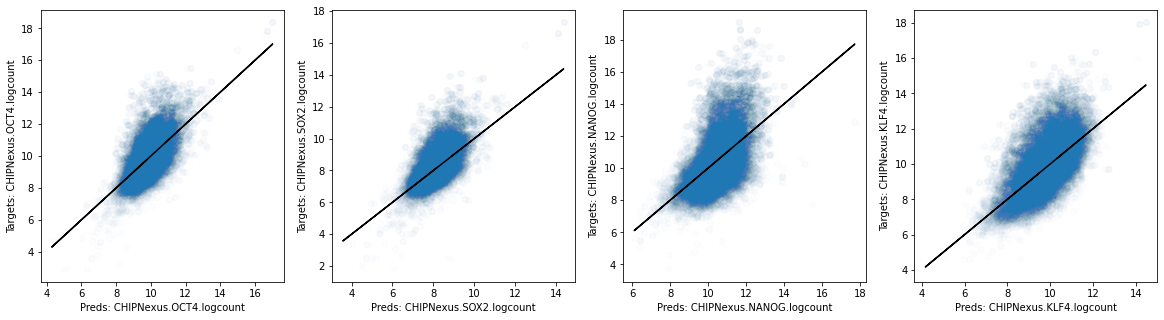

1614/1614 [==============================] - 728s 451ms/step - loss: 2500.0343 - CHIPNexus.NANOG.logcount_loss: 0.6252 - CHIPNexus.OCT4.logcount_loss: 0.2856 - CHIPNexus.KLF4.logcount_loss: 0.4282 - CHIPNexus.SOX2.logcount_loss: 0.2036 - CHIPNexus.NANOG.profile_loss: 1107.1893 - CHIPNexus.OCT4.profile_loss: 846.2538 - CHIPNexus.KLF4.profile_loss: 979.1918 - CHIPNexus.SOX2.profile_loss: 524.6785 - val_loss: 2115.5298 - val_CHIPNexus.NANOG.logcount_loss: 0.6205 - val_CHIPNexus.OCT4.logcount_loss: 0.2795 - val_CHIPNexus.KLF4.logcount_loss: 0.4352 - val_CHIPNexus.SOX2.logcount_loss: 0.2108 - val_CHIPNexus.NANOG.profile_loss: 1158.7756 - val_CHIPNexus.OCT4.profile_loss: 873.7922 - val_CHIPNexus.KLF4.profile_loss: 1006.4745 - val_CHIPNexus.SOX2.profile_loss: 521.9262
Epoch 7/200
Scatterplots before epoch 6
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5978751049650335, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6063092312930134, pvalue=0.0)
CHIPNexus.NANOG.logc

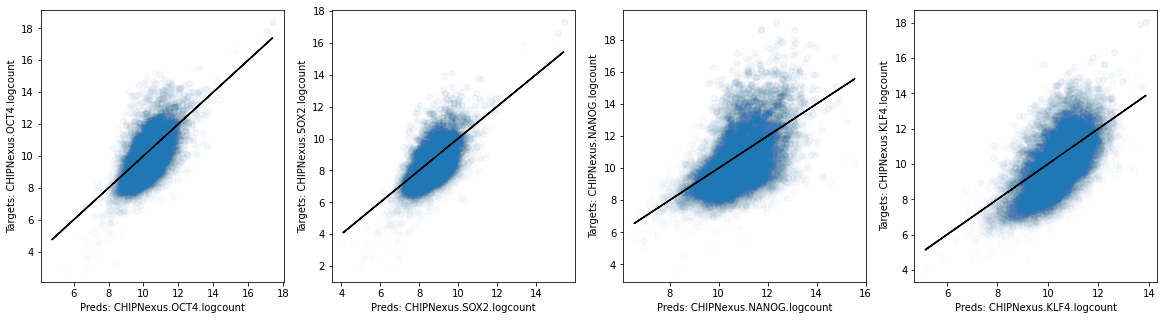

1614/1614 [==============================] - 733s 454ms/step - loss: 2433.9943 - CHIPNexus.NANOG.logcount_loss: 0.5933 - CHIPNexus.OCT4.logcount_loss: 0.2739 - CHIPNexus.KLF4.logcount_loss: 0.4030 - CHIPNexus.SOX2.logcount_loss: 0.1951 - CHIPNexus.NANOG.profile_loss: 1089.2268 - CHIPNexus.OCT4.profile_loss: 840.0283 - CHIPNexus.KLF4.profile_loss: 964.6167 - CHIPNexus.SOX2.profile_loss: 508.8575 - val_loss: 1820.9214 - val_CHIPNexus.NANOG.logcount_loss: 0.5933 - val_CHIPNexus.OCT4.logcount_loss: 0.2636 - val_CHIPNexus.KLF4.logcount_loss: 0.4039 - val_CHIPNexus.SOX2.logcount_loss: 0.2066 - val_CHIPNexus.NANOG.profile_loss: 1135.6689 - val_CHIPNexus.OCT4.profile_loss: 866.6909 - val_CHIPNexus.KLF4.profile_loss: 993.1570 - val_CHIPNexus.SOX2.profile_loss: 511.5187
Epoch 8/200
Scatterplots before epoch 7
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6202581258999746, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6277603671025098, pvalue=0.0)
CHIPNexus.NANOG.logco

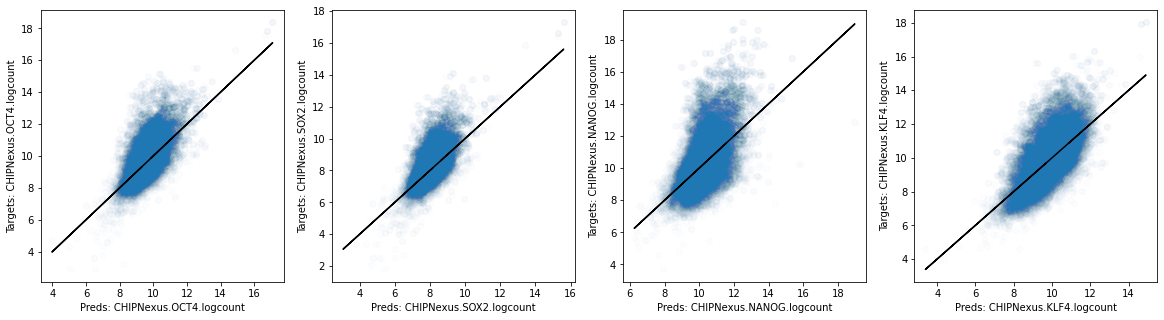

1614/1614 [==============================] - 733s 454ms/step - loss: 2364.8299 - CHIPNexus.NANOG.logcount_loss: 0.5686 - CHIPNexus.OCT4.logcount_loss: 0.2640 - CHIPNexus.KLF4.logcount_loss: 0.3742 - CHIPNexus.SOX2.logcount_loss: 0.1886 - CHIPNexus.NANOG.profile_loss: 1070.0571 - CHIPNexus.OCT4.profile_loss: 833.2915 - CHIPNexus.KLF4.profile_loss: 941.9636 - CHIPNexus.SOX2.profile_loss: 488.9351 - val_loss: 1770.7996 - val_CHIPNexus.NANOG.logcount_loss: 0.6268 - val_CHIPNexus.OCT4.logcount_loss: 0.2617 - val_CHIPNexus.KLF4.logcount_loss: 0.3861 - val_CHIPNexus.SOX2.logcount_loss: 0.1995 - val_CHIPNexus.NANOG.profile_loss: 1127.4197 - val_CHIPNexus.OCT4.profile_loss: 866.9340 - val_CHIPNexus.KLF4.profile_loss: 979.6053 - val_CHIPNexus.SOX2.profile_loss: 502.9801
Epoch 9/200
Scatterplots before epoch 8
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.585637346379054, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.5830348610711729, pvalue=0.0)
CHIPNexus.NANOG.logcou

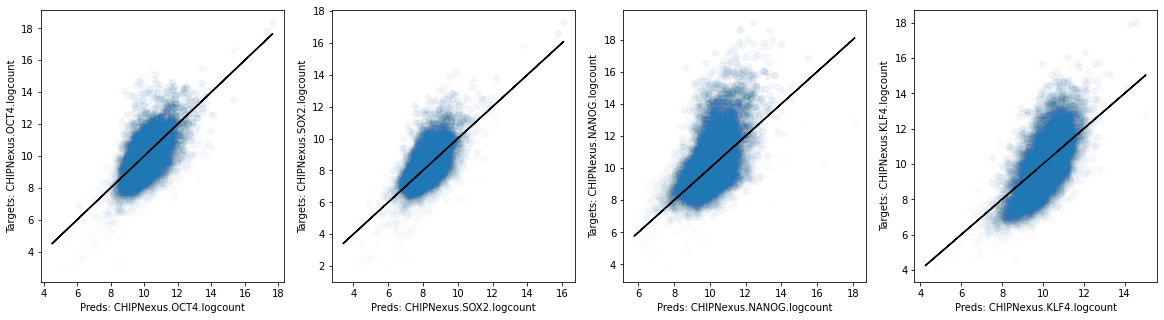

1614/1614 [==============================] - 720s 446ms/step - loss: 2328.0025 - CHIPNexus.NANOG.logcount_loss: 0.5513 - CHIPNexus.OCT4.logcount_loss: 0.2564 - CHIPNexus.KLF4.logcount_loss: 0.3575 - CHIPNexus.SOX2.logcount_loss: 0.1825 - CHIPNexus.NANOG.profile_loss: 1062.7450 - CHIPNexus.OCT4.profile_loss: 832.3831 - CHIPNexus.KLF4.profile_loss: 932.9504 - CHIPNexus.SOX2.profile_loss: 480.2619 - val_loss: 2313.5798 - val_CHIPNexus.NANOG.logcount_loss: 0.6862 - val_CHIPNexus.OCT4.logcount_loss: 0.2470 - val_CHIPNexus.KLF4.logcount_loss: 0.3897 - val_CHIPNexus.SOX2.logcount_loss: 0.2025 - val_CHIPNexus.NANOG.profile_loss: 1117.5522 - val_CHIPNexus.OCT4.profile_loss: 868.3001 - val_CHIPNexus.KLF4.profile_loss: 978.6879 - val_CHIPNexus.SOX2.profile_loss: 503.7762
Epoch 10/200
Scatterplots before epoch 9
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6346793819354897, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6184113655595938, pvalue=0.0)
CHIPNexus.NANOG.logc

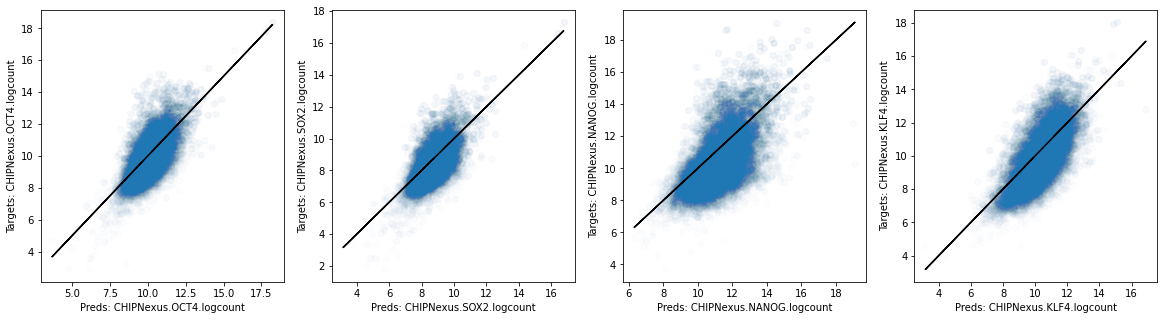

1614/1614 [==============================] - 719s 446ms/step - loss: 2291.1404 - CHIPNexus.NANOG.logcount_loss: 0.5262 - CHIPNexus.OCT4.logcount_loss: 0.2487 - CHIPNexus.KLF4.logcount_loss: 0.3446 - CHIPNexus.SOX2.logcount_loss: 0.1764 - CHIPNexus.NANOG.profile_loss: 1055.3806 - CHIPNexus.OCT4.profile_loss: 830.9297 - CHIPNexus.KLF4.profile_loss: 925.1071 - CHIPNexus.SOX2.profile_loss: 474.9592 - val_loss: 1788.6128 - val_CHIPNexus.NANOG.logcount_loss: 0.5775 - val_CHIPNexus.OCT4.logcount_loss: 0.2518 - val_CHIPNexus.KLF4.logcount_loss: 0.3637 - val_CHIPNexus.SOX2.logcount_loss: 0.1898 - val_CHIPNexus.NANOG.profile_loss: 1110.4275 - val_CHIPNexus.OCT4.profile_loss: 864.5638 - val_CHIPNexus.KLF4.profile_loss: 966.2473 - val_CHIPNexus.SOX2.profile_loss: 497.3704
Epoch 11/200
Scatterplots before epoch 10
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6399764593355496, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6255043787017442, pvalue=0.0)
CHIPNexus.NANOG.log

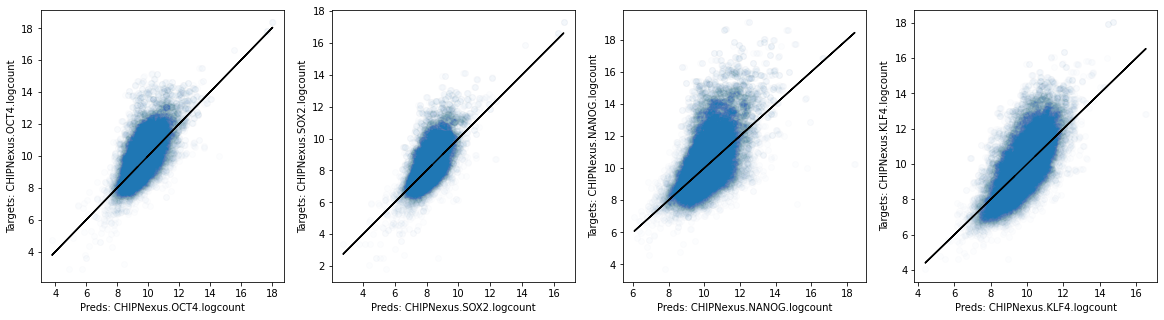

1614/1614 [==============================] - 730s 452ms/step - loss: 2258.5606 - CHIPNexus.NANOG.logcount_loss: 0.5072 - CHIPNexus.OCT4.logcount_loss: 0.2412 - CHIPNexus.KLF4.logcount_loss: 0.3350 - CHIPNexus.SOX2.logcount_loss: 0.1710 - CHIPNexus.NANOG.profile_loss: 1048.9554 - CHIPNexus.OCT4.profile_loss: 828.5152 - CHIPNexus.KLF4.profile_loss: 915.7017 - CHIPNexus.SOX2.profile_loss: 469.5399 - val_loss: 1935.4081 - val_CHIPNexus.NANOG.logcount_loss: 0.5378 - val_CHIPNexus.OCT4.logcount_loss: 0.2335 - val_CHIPNexus.KLF4.logcount_loss: 0.3481 - val_CHIPNexus.SOX2.logcount_loss: 0.1774 - val_CHIPNexus.NANOG.profile_loss: 1111.1580 - val_CHIPNexus.OCT4.profile_loss: 863.0822 - val_CHIPNexus.KLF4.profile_loss: 959.2349 - val_CHIPNexus.SOX2.profile_loss: 492.6144
Epoch 12/200
Scatterplots before epoch 11
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6341381696382619, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.621128403447253, pvalue=0.0)
CHIPNexus.NANOG.logc

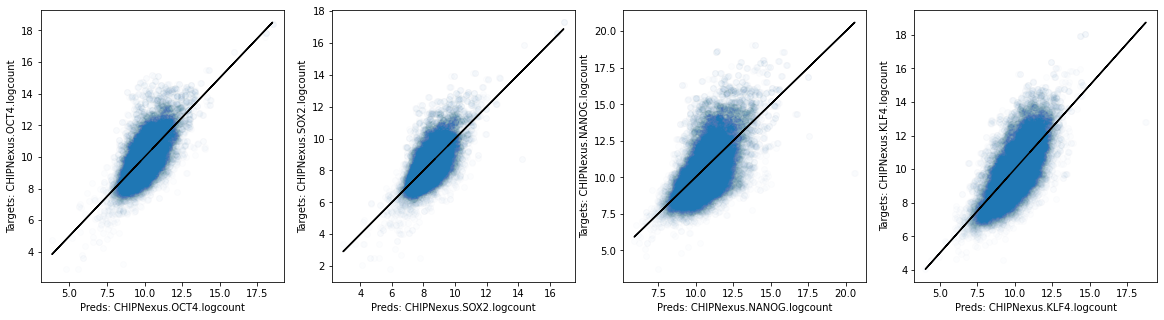

1614/1614 [==============================] - 751s 465ms/step - loss: 2227.5305 - CHIPNexus.NANOG.logcount_loss: 0.4829 - CHIPNexus.OCT4.logcount_loss: 0.2330 - CHIPNexus.KLF4.logcount_loss: 0.3234 - CHIPNexus.SOX2.logcount_loss: 0.1639 - CHIPNexus.NANOG.profile_loss: 1046.6678 - CHIPNexus.OCT4.profile_loss: 829.4004 - CHIPNexus.KLF4.profile_loss: 910.7921 - CHIPNexus.SOX2.profile_loss: 465.0593 - val_loss: 1771.1892 - val_CHIPNexus.NANOG.logcount_loss: 0.5261 - val_CHIPNexus.OCT4.logcount_loss: 0.2270 - val_CHIPNexus.KLF4.logcount_loss: 0.3466 - val_CHIPNexus.SOX2.logcount_loss: 0.1773 - val_CHIPNexus.NANOG.profile_loss: 1111.2971 - val_CHIPNexus.OCT4.profile_loss: 864.7396 - val_CHIPNexus.KLF4.profile_loss: 954.1485 - val_CHIPNexus.SOX2.profile_loss: 493.5243
Epoch 13/200
Scatterplots before epoch 12
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6487181826475634, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6328051946548049, pvalue=0.0)
CHIPNexus.NANOG.log

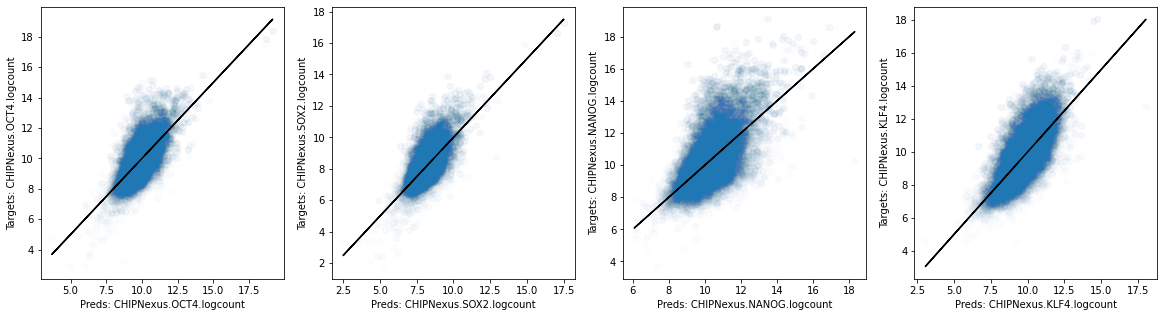

1614/1614 [==============================] - 722s 447ms/step - loss: 2201.3320 - CHIPNexus.NANOG.logcount_loss: 0.4640 - CHIPNexus.OCT4.logcount_loss: 0.2256 - CHIPNexus.KLF4.logcount_loss: 0.3148 - CHIPNexus.SOX2.logcount_loss: 0.1584 - CHIPNexus.NANOG.profile_loss: 1043.0741 - CHIPNexus.OCT4.profile_loss: 826.9708 - CHIPNexus.KLF4.profile_loss: 906.9718 - CHIPNexus.SOX2.profile_loss: 462.8939 - val_loss: 2063.5178 - val_CHIPNexus.NANOG.logcount_loss: 0.6636 - val_CHIPNexus.OCT4.logcount_loss: 0.2327 - val_CHIPNexus.KLF4.logcount_loss: 0.3691 - val_CHIPNexus.SOX2.logcount_loss: 0.1873 - val_CHIPNexus.NANOG.profile_loss: 1108.2305 - val_CHIPNexus.OCT4.profile_loss: 865.0858 - val_CHIPNexus.KLF4.profile_loss: 945.6782 - val_CHIPNexus.SOX2.profile_loss: 491.3098
Epoch 14/200
Scatterplots before epoch 13
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.644876133382668, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6311548671404432, pvalue=0.0)
CHIPNexus.NANOG.logc

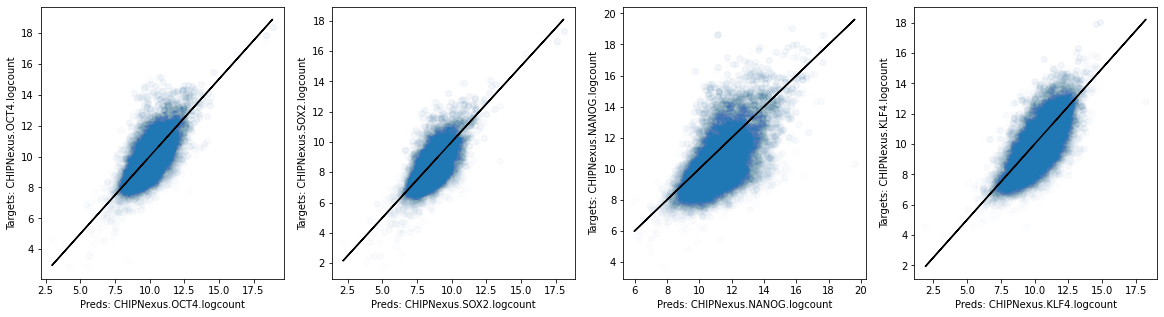

1614/1614 [==============================] - 714s 443ms/step - loss: 2164.0569 - CHIPNexus.NANOG.logcount_loss: 0.4352 - CHIPNexus.OCT4.logcount_loss: 0.2150 - CHIPNexus.KLF4.logcount_loss: 0.2988 - CHIPNexus.SOX2.logcount_loss: 0.1490 - CHIPNexus.NANOG.profile_loss: 1040.9912 - CHIPNexus.OCT4.profile_loss: 826.2263 - CHIPNexus.KLF4.profile_loss: 902.0063 - CHIPNexus.SOX2.profile_loss: 460.7906 - val_loss: 1947.4595 - val_CHIPNexus.NANOG.logcount_loss: 0.5125 - val_CHIPNexus.OCT4.logcount_loss: 0.2243 - val_CHIPNexus.KLF4.logcount_loss: 0.3384 - val_CHIPNexus.SOX2.logcount_loss: 0.1730 - val_CHIPNexus.NANOG.profile_loss: 1106.7603 - val_CHIPNexus.OCT4.profile_loss: 861.8695 - val_CHIPNexus.KLF4.profile_loss: 939.9734 - val_CHIPNexus.SOX2.profile_loss: 491.4200
Epoch 15/200
Scatterplots before epoch 14
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6562078995816788, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6353690529701326, pvalue=0.0)
CHIPNexus.NANOG.log

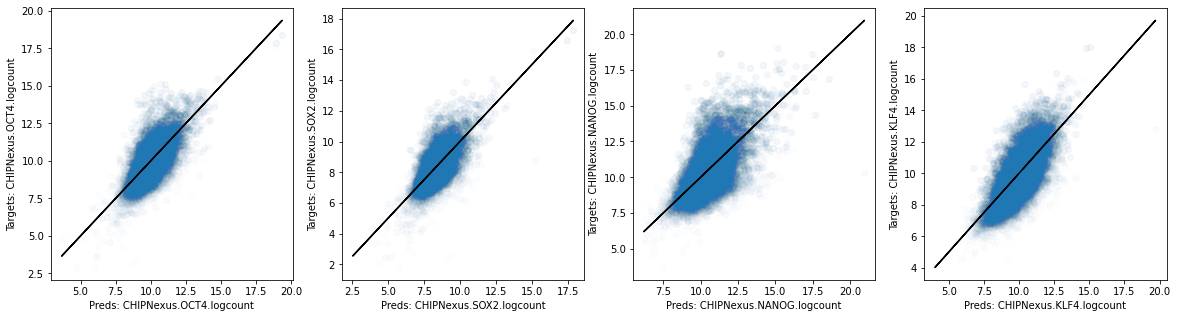

1614/1614 [==============================] - 717s 444ms/step - loss: 2142.4318 - CHIPNexus.NANOG.logcount_loss: 0.4159 - CHIPNexus.OCT4.logcount_loss: 0.2085 - CHIPNexus.KLF4.logcount_loss: 0.2906 - CHIPNexus.SOX2.logcount_loss: 0.1439 - CHIPNexus.NANOG.profile_loss: 1041.1265 - CHIPNexus.OCT4.profile_loss: 826.3470 - CHIPNexus.KLF4.profile_loss: 899.3666 - CHIPNexus.SOX2.profile_loss: 459.1770 - val_loss: 1724.5023 - val_CHIPNexus.NANOG.logcount_loss: 0.5126 - val_CHIPNexus.OCT4.logcount_loss: 0.2236 - val_CHIPNexus.KLF4.logcount_loss: 0.3454 - val_CHIPNexus.SOX2.logcount_loss: 0.1704 - val_CHIPNexus.NANOG.profile_loss: 1109.8864 - val_CHIPNexus.OCT4.profile_loss: 862.5588 - val_CHIPNexus.KLF4.profile_loss: 933.4650 - val_CHIPNexus.SOX2.profile_loss: 489.7766
Epoch 16/200
Scatterplots before epoch 15
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6496440146537814, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.637247139368461, pvalue=0.0)
CHIPNexus.NANOG.logc

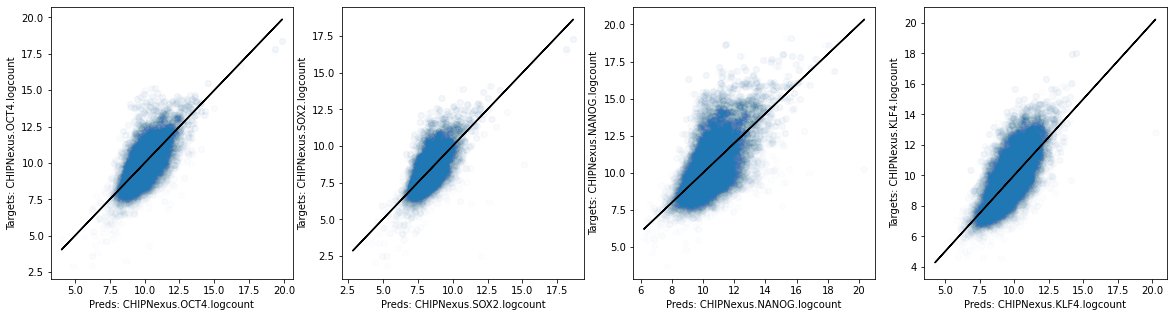

1614/1614 [==============================] - 718s 445ms/step - loss: 2123.9908 - CHIPNexus.NANOG.logcount_loss: 0.4015 - CHIPNexus.OCT4.logcount_loss: 0.2024 - CHIPNexus.KLF4.logcount_loss: 0.2823 - CHIPNexus.SOX2.logcount_loss: 0.1388 - CHIPNexus.NANOG.profile_loss: 1039.8536 - CHIPNexus.OCT4.profile_loss: 825.1994 - CHIPNexus.KLF4.profile_loss: 898.6071 - CHIPNexus.SOX2.profile_loss: 459.3961 - val_loss: 1840.3838 - val_CHIPNexus.NANOG.logcount_loss: 0.5280 - val_CHIPNexus.OCT4.logcount_loss: 0.2255 - val_CHIPNexus.KLF4.logcount_loss: 0.3376 - val_CHIPNexus.SOX2.logcount_loss: 0.1698 - val_CHIPNexus.NANOG.profile_loss: 1109.1512 - val_CHIPNexus.OCT4.profile_loss: 866.3088 - val_CHIPNexus.KLF4.profile_loss: 931.1778 - val_CHIPNexus.SOX2.profile_loss: 492.7496
Epoch 17/200
Scatterplots before epoch 16
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6566645680989348, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6390878899816725, pvalue=0.0)
CHIPNexus.NANOG.log

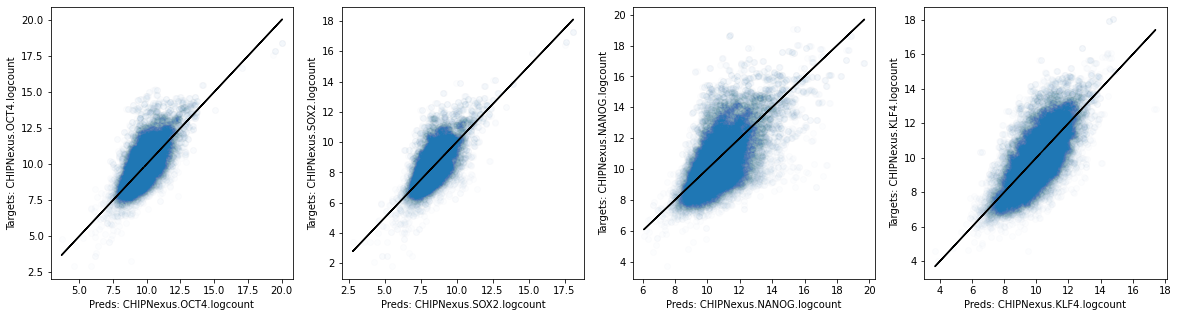

1614/1614 [==============================] - 711s 441ms/step - loss: 2093.1142 - CHIPNexus.NANOG.logcount_loss: 0.3763 - CHIPNexus.OCT4.logcount_loss: 0.1931 - CHIPNexus.KLF4.logcount_loss: 0.2691 - CHIPNexus.SOX2.logcount_loss: 0.1309 - CHIPNexus.NANOG.profile_loss: 1038.5294 - CHIPNexus.OCT4.profile_loss: 824.6064 - CHIPNexus.KLF4.profile_loss: 895.5792 - CHIPNexus.SOX2.profile_loss: 457.9603 - val_loss: 1699.7533 - val_CHIPNexus.NANOG.logcount_loss: 0.5241 - val_CHIPNexus.OCT4.logcount_loss: 0.2313 - val_CHIPNexus.KLF4.logcount_loss: 0.3414 - val_CHIPNexus.SOX2.logcount_loss: 0.1723 - val_CHIPNexus.NANOG.profile_loss: 1111.0662 - val_CHIPNexus.OCT4.profile_loss: 862.5145 - val_CHIPNexus.KLF4.profile_loss: 929.5031 - val_CHIPNexus.SOX2.profile_loss: 490.5898
Epoch 18/200
Scatterplots before epoch 17
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6605306162026726, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6380718665309422, pvalue=0.0)
CHIPNexus.NANOG.log

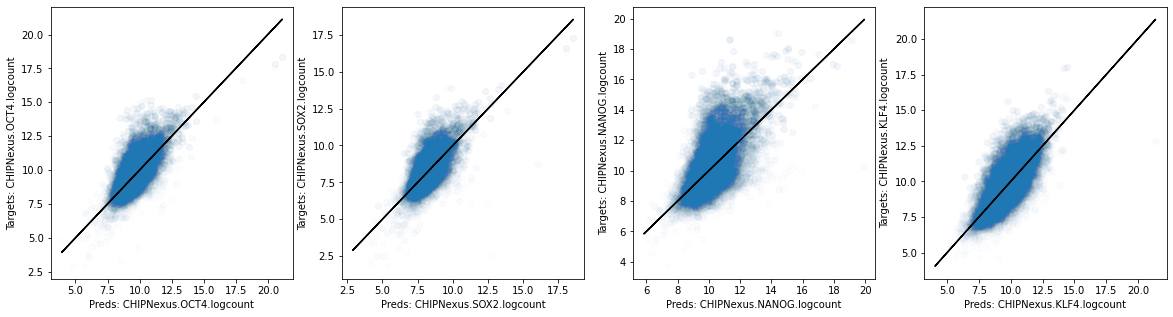

1614/1614 [==============================] - 709s 439ms/step - loss: 2077.8658 - CHIPNexus.NANOG.logcount_loss: 0.3623 - CHIPNexus.OCT4.logcount_loss: 0.1877 - CHIPNexus.KLF4.logcount_loss: 0.2621 - CHIPNexus.SOX2.logcount_loss: 0.1266 - CHIPNexus.NANOG.profile_loss: 1038.4298 - CHIPNexus.OCT4.profile_loss: 824.8752 - CHIPNexus.KLF4.profile_loss: 895.7797 - CHIPNexus.SOX2.profile_loss: 457.8676 - val_loss: 2014.3984 - val_CHIPNexus.NANOG.logcount_loss: 0.5056 - val_CHIPNexus.OCT4.logcount_loss: 0.2436 - val_CHIPNexus.KLF4.logcount_loss: 0.3354 - val_CHIPNexus.SOX2.logcount_loss: 0.1733 - val_CHIPNexus.NANOG.profile_loss: 1109.0226 - val_CHIPNexus.OCT4.profile_loss: 863.5790 - val_CHIPNexus.KLF4.profile_loss: 930.9618 - val_CHIPNexus.SOX2.profile_loss: 489.9915
Epoch 19/200
Scatterplots before epoch 18
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6576021835507113, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6368262732936838, pvalue=0.0)
CHIPNexus.NANOG.log

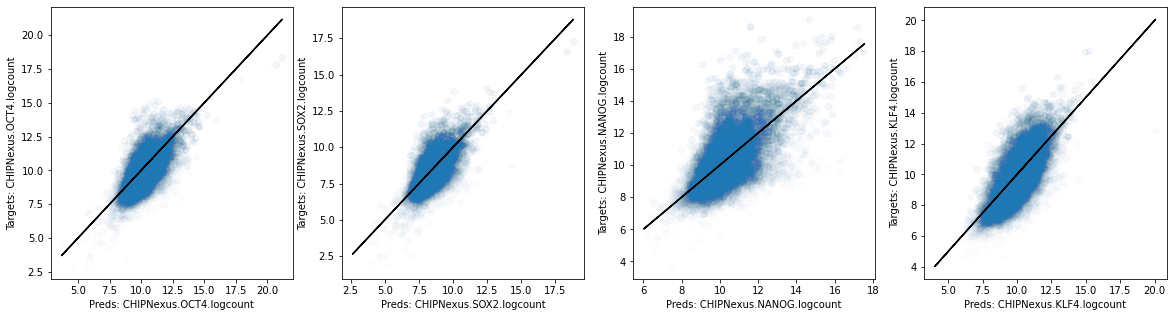

1614/1614 [==============================] - 712s 441ms/step - loss: 2057.0718 - CHIPNexus.NANOG.logcount_loss: 0.3466 - CHIPNexus.OCT4.logcount_loss: 0.1813 - CHIPNexus.KLF4.logcount_loss: 0.2533 - CHIPNexus.SOX2.logcount_loss: 0.1211 - CHIPNexus.NANOG.profile_loss: 1037.5184 - CHIPNexus.OCT4.profile_loss: 822.9013 - CHIPNexus.KLF4.profile_loss: 893.8704 - CHIPNexus.SOX2.profile_loss: 457.6806 - val_loss: 1746.7823 - val_CHIPNexus.NANOG.logcount_loss: 0.5126 - val_CHIPNexus.OCT4.logcount_loss: 0.2443 - val_CHIPNexus.KLF4.logcount_loss: 0.3794 - val_CHIPNexus.SOX2.logcount_loss: 0.1847 - val_CHIPNexus.NANOG.profile_loss: 1107.1602 - val_CHIPNexus.OCT4.profile_loss: 862.8614 - val_CHIPNexus.KLF4.profile_loss: 932.6345 - val_CHIPNexus.SOX2.profile_loss: 490.7124
Epoch 20/200
Scatterplots before epoch 19
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.665685678723865, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6412183444588461, pvalue=0.0)
CHIPNexus.NANOG.logc

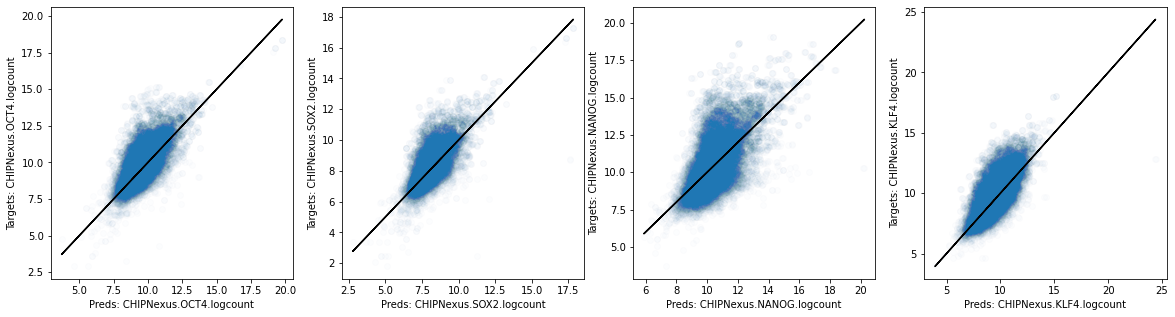

1614/1614 [==============================] - 714s 442ms/step - loss: 2047.2215 - CHIPNexus.NANOG.logcount_loss: 0.3368 - CHIPNexus.OCT4.logcount_loss: 0.1773 - CHIPNexus.KLF4.logcount_loss: 0.2489 - CHIPNexus.SOX2.logcount_loss: 0.1182 - CHIPNexus.NANOG.profile_loss: 1037.5769 - CHIPNexus.OCT4.profile_loss: 823.4542 - CHIPNexus.KLF4.profile_loss: 894.8773 - CHIPNexus.SOX2.profile_loss: 457.3351 - val_loss: 1840.5734 - val_CHIPNexus.NANOG.logcount_loss: 0.5191 - val_CHIPNexus.OCT4.logcount_loss: 0.2227 - val_CHIPNexus.KLF4.logcount_loss: 0.3409 - val_CHIPNexus.SOX2.logcount_loss: 0.1748 - val_CHIPNexus.NANOG.profile_loss: 1112.8411 - val_CHIPNexus.OCT4.profile_loss: 862.0948 - val_CHIPNexus.KLF4.profile_loss: 931.6967 - val_CHIPNexus.SOX2.profile_loss: 489.9423
Epoch 21/200
Scatterplots before epoch 20
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.657351373983773, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6394042700980465, pvalue=0.0)
CHIPNexus.NANOG.logc

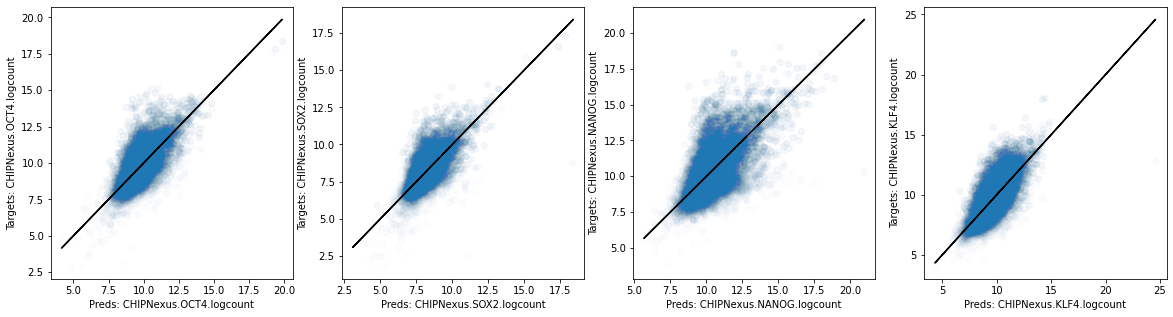

1614/1614 [==============================] - 707s 438ms/step - loss: 2032.4137 - CHIPNexus.NANOG.logcount_loss: 0.3243 - CHIPNexus.OCT4.logcount_loss: 0.1718 - CHIPNexus.KLF4.logcount_loss: 0.2414 - CHIPNexus.SOX2.logcount_loss: 0.1146 - CHIPNexus.NANOG.profile_loss: 1037.5420 - CHIPNexus.OCT4.profile_loss: 823.5677 - CHIPNexus.KLF4.profile_loss: 893.8520 - CHIPNexus.SOX2.profile_loss: 457.7984 - val_loss: 1667.5090 - val_CHIPNexus.NANOG.logcount_loss: 0.5488 - val_CHIPNexus.OCT4.logcount_loss: 0.2328 - val_CHIPNexus.KLF4.logcount_loss: 0.3874 - val_CHIPNexus.SOX2.logcount_loss: 0.1776 - val_CHIPNexus.NANOG.profile_loss: 1110.3926 - val_CHIPNexus.OCT4.profile_loss: 863.1750 - val_CHIPNexus.KLF4.profile_loss: 934.2997 - val_CHIPNexus.SOX2.profile_loss: 490.5968
Epoch 22/200
Scatterplots before epoch 21
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6524919039275208, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6339262297084381, pvalue=0.0)
CHIPNexus.NANOG.log

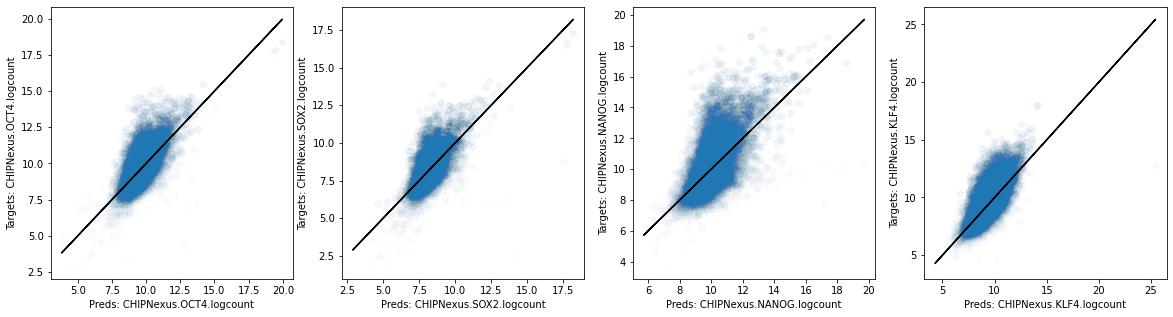

1614/1614 [==============================] - 712s 441ms/step - loss: 2014.6400 - CHIPNexus.NANOG.logcount_loss: 0.3104 - CHIPNexus.OCT4.logcount_loss: 0.1662 - CHIPNexus.KLF4.logcount_loss: 0.2336 - CHIPNexus.SOX2.logcount_loss: 0.1103 - CHIPNexus.NANOG.profile_loss: 1036.2751 - CHIPNexus.OCT4.profile_loss: 821.7828 - CHIPNexus.KLF4.profile_loss: 893.7438 - CHIPNexus.SOX2.profile_loss: 457.0527 - val_loss: 2076.5466 - val_CHIPNexus.NANOG.logcount_loss: 0.5360 - val_CHIPNexus.OCT4.logcount_loss: 0.2297 - val_CHIPNexus.KLF4.logcount_loss: 0.3504 - val_CHIPNexus.SOX2.logcount_loss: 0.1761 - val_CHIPNexus.NANOG.profile_loss: 1107.3807 - val_CHIPNexus.OCT4.profile_loss: 862.4828 - val_CHIPNexus.KLF4.profile_loss: 932.1204 - val_CHIPNexus.SOX2.profile_loss: 490.1660
Epoch 23/200
Scatterplots before epoch 22
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6542796264489005, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6361107421055759, pvalue=0.0)
CHIPNexus.NANOG.log

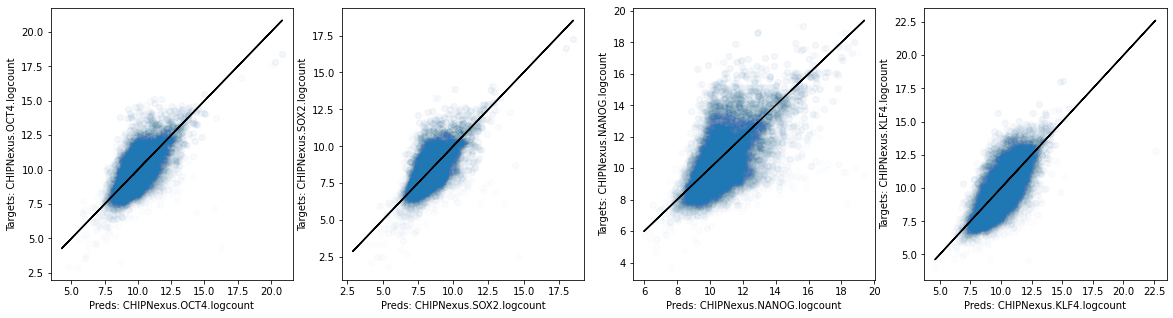

1614/1614 [==============================] - 707s 438ms/step - loss: 2005.5631 - CHIPNexus.NANOG.logcount_loss: 0.3024 - CHIPNexus.OCT4.logcount_loss: 0.1628 - CHIPNexus.KLF4.logcount_loss: 0.2290 - CHIPNexus.SOX2.logcount_loss: 0.1079 - CHIPNexus.NANOG.profile_loss: 1036.2092 - CHIPNexus.OCT4.profile_loss: 822.0769 - CHIPNexus.KLF4.profile_loss: 893.7022 - CHIPNexus.SOX2.profile_loss: 456.9932 - val_loss: 1988.8296 - val_CHIPNexus.NANOG.logcount_loss: 0.5395 - val_CHIPNexus.OCT4.logcount_loss: 0.2233 - val_CHIPNexus.KLF4.logcount_loss: 0.3426 - val_CHIPNexus.SOX2.logcount_loss: 0.1763 - val_CHIPNexus.NANOG.profile_loss: 1110.6527 - val_CHIPNexus.OCT4.profile_loss: 864.8812 - val_CHIPNexus.KLF4.profile_loss: 932.7773 - val_CHIPNexus.SOX2.profile_loss: 491.4561
Epoch 24/200
Scatterplots before epoch 23
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6610713490418281, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6415694846129499, pvalue=0.0)
CHIPNexus.NANOG.log

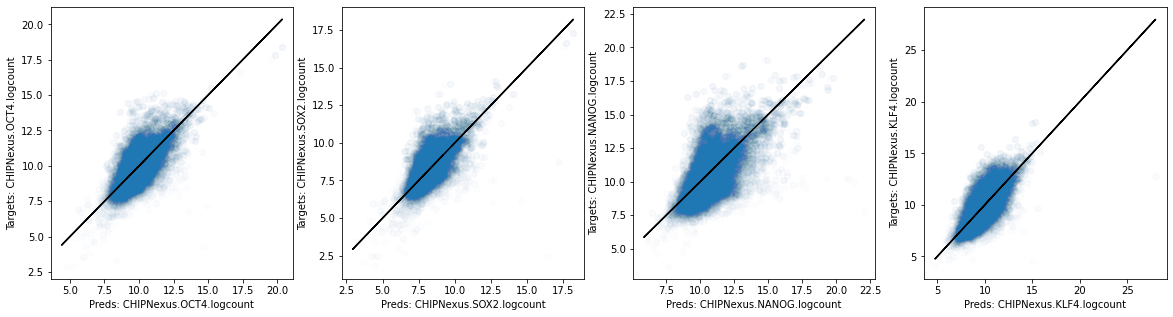

1614/1614 [==============================] - 705s 437ms/step - loss: 1996.0283 - CHIPNexus.NANOG.logcount_loss: 0.2948 - CHIPNexus.OCT4.logcount_loss: 0.1591 - CHIPNexus.KLF4.logcount_loss: 0.2241 - CHIPNexus.SOX2.logcount_loss: 0.1056 - CHIPNexus.NANOG.profile_loss: 1035.5909 - CHIPNexus.OCT4.profile_loss: 821.8468 - CHIPNexus.KLF4.profile_loss: 893.7629 - CHIPNexus.SOX2.profile_loss: 457.3211 - val_loss: 1907.3928 - val_CHIPNexus.NANOG.logcount_loss: 0.5193 - val_CHIPNexus.OCT4.logcount_loss: 0.2334 - val_CHIPNexus.KLF4.logcount_loss: 0.3450 - val_CHIPNexus.SOX2.logcount_loss: 0.1788 - val_CHIPNexus.NANOG.profile_loss: 1110.0015 - val_CHIPNexus.OCT4.profile_loss: 864.4536 - val_CHIPNexus.KLF4.profile_loss: 932.9026 - val_CHIPNexus.SOX2.profile_loss: 490.9516
Epoch 25/200
Scatterplots before epoch 24
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6480355715999012, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6361581152975855, pvalue=0.0)
CHIPNexus.NANOG.log

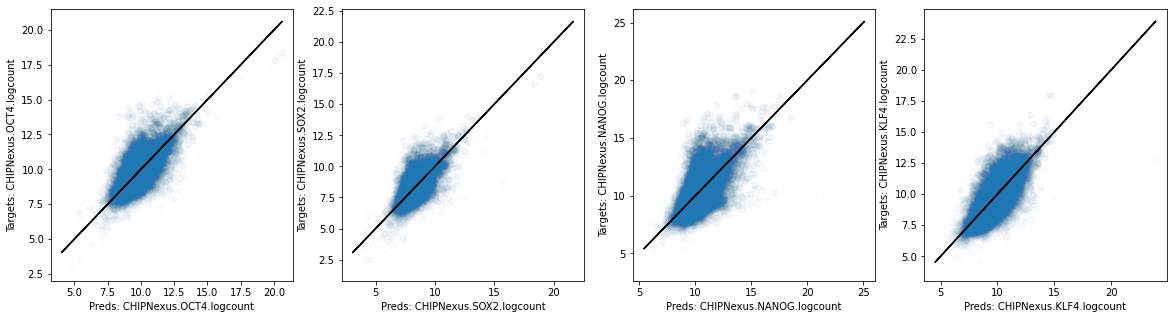

1614/1614 [==============================] - 714s 442ms/step - loss: 1981.7007 - CHIPNexus.NANOG.logcount_loss: 0.2829 - CHIPNexus.OCT4.logcount_loss: 0.1533 - CHIPNexus.KLF4.logcount_loss: 0.2177 - CHIPNexus.SOX2.logcount_loss: 0.1027 - CHIPNexus.NANOG.profile_loss: 1035.8042 - CHIPNexus.OCT4.profile_loss: 820.8006 - CHIPNexus.KLF4.profile_loss: 893.3074 - CHIPNexus.SOX2.profile_loss: 456.9664 - val_loss: 1979.0453 - val_CHIPNexus.NANOG.logcount_loss: 0.5356 - val_CHIPNexus.OCT4.logcount_loss: 0.2319 - val_CHIPNexus.KLF4.logcount_loss: 0.3445 - val_CHIPNexus.SOX2.logcount_loss: 0.1779 - val_CHIPNexus.NANOG.profile_loss: 1109.0009 - val_CHIPNexus.OCT4.profile_loss: 865.6453 - val_CHIPNexus.KLF4.profile_loss: 934.1010 - val_CHIPNexus.SOX2.profile_loss: 491.5050
Epoch 26/200
Scatterplots before epoch 25
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6505389462411063, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6335026106195303, pvalue=0.0)
CHIPNexus.NANOG.log

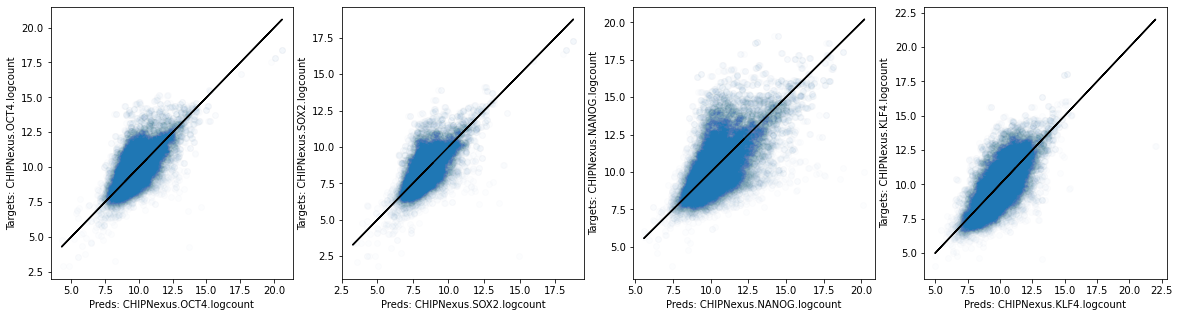

1614/1614 [==============================] - 707s 438ms/step - loss: 1973.9596 - CHIPNexus.NANOG.logcount_loss: 0.2769 - CHIPNexus.OCT4.logcount_loss: 0.1495 - CHIPNexus.KLF4.logcount_loss: 0.2148 - CHIPNexus.SOX2.logcount_loss: 0.1009 - CHIPNexus.NANOG.profile_loss: 1034.9381 - CHIPNexus.OCT4.profile_loss: 820.2492 - CHIPNexus.KLF4.profile_loss: 893.5881 - CHIPNexus.SOX2.profile_loss: 457.2139 - val_loss: 1774.5114 - val_CHIPNexus.NANOG.logcount_loss: 0.5458 - val_CHIPNexus.OCT4.logcount_loss: 0.2264 - val_CHIPNexus.KLF4.logcount_loss: 0.3383 - val_CHIPNexus.SOX2.logcount_loss: 0.1779 - val_CHIPNexus.NANOG.profile_loss: 1113.9348 - val_CHIPNexus.OCT4.profile_loss: 864.3188 - val_CHIPNexus.KLF4.profile_loss: 933.2587 - val_CHIPNexus.SOX2.profile_loss: 490.8842
Epoch 27/200
Scatterplots before epoch 26
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6569655945767879, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6371415449662056, pvalue=0.0)
CHIPNexus.NANOG.log

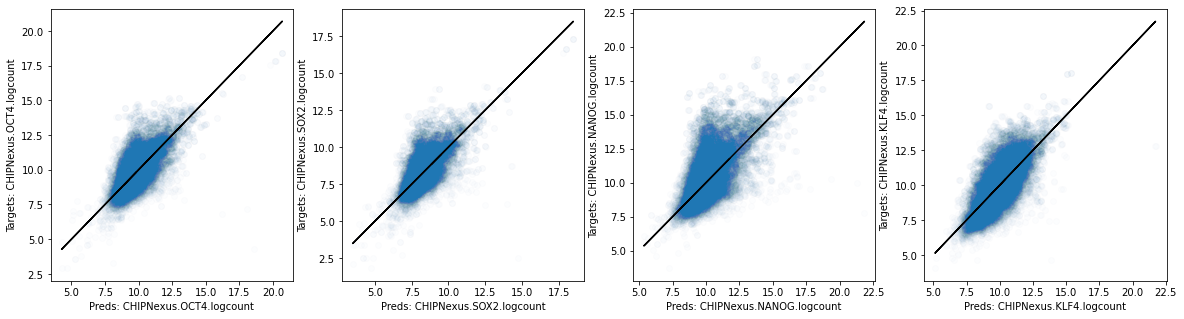

1614/1614 [==============================] - 716s 443ms/step - loss: 1964.6077 - CHIPNexus.NANOG.logcount_loss: 0.2693 - CHIPNexus.OCT4.logcount_loss: 0.1438 - CHIPNexus.KLF4.logcount_loss: 0.2109 - CHIPNexus.SOX2.logcount_loss: 0.0986 - CHIPNexus.NANOG.profile_loss: 1034.7668 - CHIPNexus.OCT4.profile_loss: 821.1412 - CHIPNexus.KLF4.profile_loss: 893.6264 - CHIPNexus.SOX2.profile_loss: 457.0248 - val_loss: 1707.9586 - val_CHIPNexus.NANOG.logcount_loss: 0.5845 - val_CHIPNexus.OCT4.logcount_loss: 0.2327 - val_CHIPNexus.KLF4.logcount_loss: 0.3473 - val_CHIPNexus.SOX2.logcount_loss: 0.1855 - val_CHIPNexus.NANOG.profile_loss: 1110.5798 - val_CHIPNexus.OCT4.profile_loss: 862.6934 - val_CHIPNexus.KLF4.profile_loss: 932.3719 - val_CHIPNexus.SOX2.profile_loss: 490.2530
Epoch 28/200
Scatterplots before epoch 27
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6583760852936326, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6396107024776726, pvalue=0.0)
CHIPNexus.NANOG.log

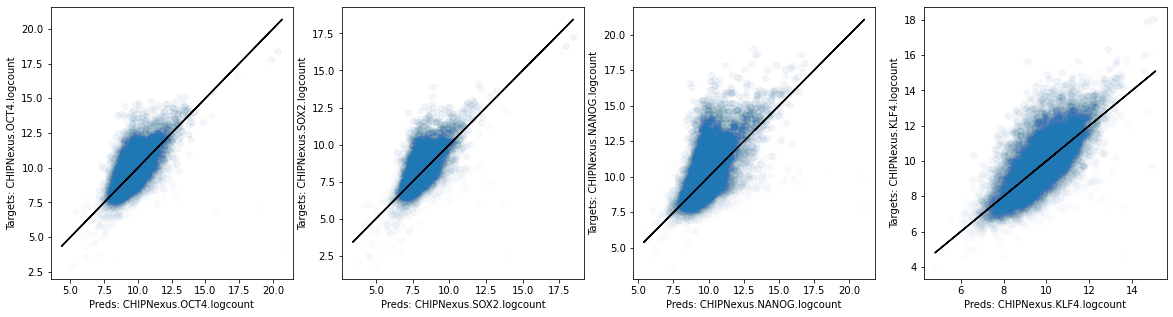

1614/1614 [==============================] - 715s 443ms/step - loss: 1956.2826 - CHIPNexus.NANOG.logcount_loss: 0.2645 - CHIPNexus.OCT4.logcount_loss: 0.1387 - CHIPNexus.KLF4.logcount_loss: 0.2078 - CHIPNexus.SOX2.logcount_loss: 0.0976 - CHIPNexus.NANOG.profile_loss: 1034.3864 - CHIPNexus.OCT4.profile_loss: 818.6532 - CHIPNexus.KLF4.profile_loss: 893.0846 - CHIPNexus.SOX2.profile_loss: 457.8556 - val_loss: 2065.1887 - val_CHIPNexus.NANOG.logcount_loss: 0.5531 - val_CHIPNexus.OCT4.logcount_loss: 0.2352 - val_CHIPNexus.KLF4.logcount_loss: 0.3520 - val_CHIPNexus.SOX2.logcount_loss: 0.1765 - val_CHIPNexus.NANOG.profile_loss: 1113.5765 - val_CHIPNexus.OCT4.profile_loss: 861.7802 - val_CHIPNexus.KLF4.profile_loss: 934.1083 - val_CHIPNexus.SOX2.profile_loss: 490.8148
Epoch 29/200
Scatterplots before epoch 28
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6527581536151784, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6389493715622312, pvalue=0.0)
CHIPNexus.NANOG.log

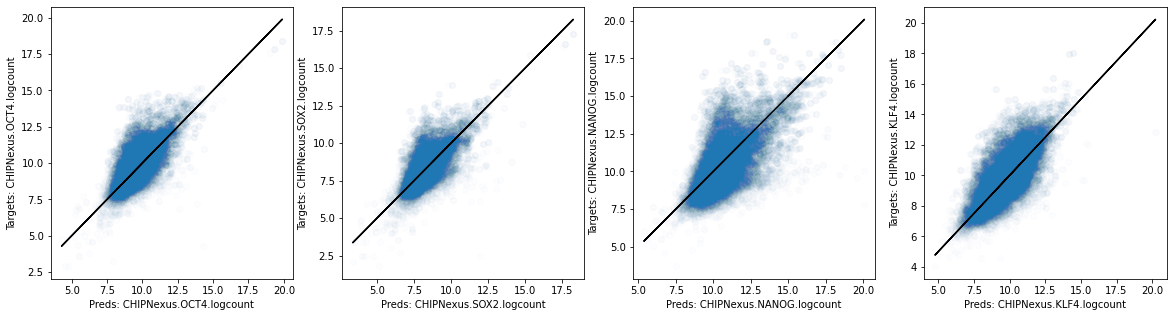

1614/1614 [==============================] - 726s 450ms/step - loss: 1950.0704 - CHIPNexus.NANOG.logcount_loss: 0.2599 - CHIPNexus.OCT4.logcount_loss: 0.1360 - CHIPNexus.KLF4.logcount_loss: 0.2054 - CHIPNexus.SOX2.logcount_loss: 0.0965 - CHIPNexus.NANOG.profile_loss: 1033.7366 - CHIPNexus.OCT4.profile_loss: 818.8761 - CHIPNexus.KLF4.profile_loss: 892.9804 - CHIPNexus.SOX2.profile_loss: 456.7894 - val_loss: 2108.6477 - val_CHIPNexus.NANOG.logcount_loss: 0.5468 - val_CHIPNexus.OCT4.logcount_loss: 0.2259 - val_CHIPNexus.KLF4.logcount_loss: 0.3411 - val_CHIPNexus.SOX2.logcount_loss: 0.1725 - val_CHIPNexus.NANOG.profile_loss: 1112.1198 - val_CHIPNexus.OCT4.profile_loss: 862.9187 - val_CHIPNexus.KLF4.profile_loss: 934.9510 - val_CHIPNexus.SOX2.profile_loss: 490.6076
Epoch 30/200
Scatterplots before epoch 29
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6572788328817312, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6404057632317217, pvalue=0.0)
CHIPNexus.NANOG.log

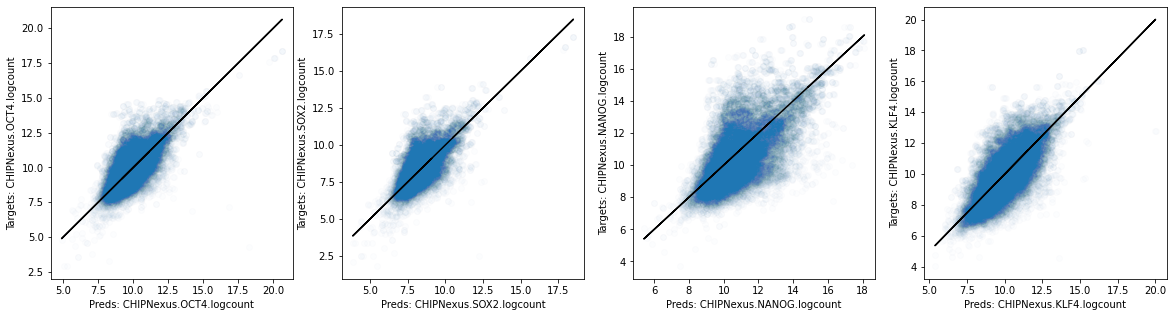

1614/1614 [==============================] - 719s 445ms/step - loss: 1940.1067 - CHIPNexus.NANOG.logcount_loss: 0.2531 - CHIPNexus.OCT4.logcount_loss: 0.1324 - CHIPNexus.KLF4.logcount_loss: 0.2012 - CHIPNexus.SOX2.logcount_loss: 0.0944 - CHIPNexus.NANOG.profile_loss: 1033.5746 - CHIPNexus.OCT4.profile_loss: 816.2931 - CHIPNexus.KLF4.profile_loss: 892.9337 - CHIPNexus.SOX2.profile_loss: 456.3685 - val_loss: 1880.8810 - val_CHIPNexus.NANOG.logcount_loss: 0.5358 - val_CHIPNexus.OCT4.logcount_loss: 0.2217 - val_CHIPNexus.KLF4.logcount_loss: 0.3623 - val_CHIPNexus.SOX2.logcount_loss: 0.1820 - val_CHIPNexus.NANOG.profile_loss: 1113.9098 - val_CHIPNexus.OCT4.profile_loss: 861.4869 - val_CHIPNexus.KLF4.profile_loss: 933.2134 - val_CHIPNexus.SOX2.profile_loss: 490.1133
Epoch 31/200
Scatterplots before epoch 30
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6605527477235275, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6378242545764689, pvalue=0.0)
CHIPNexus.NANOG.log

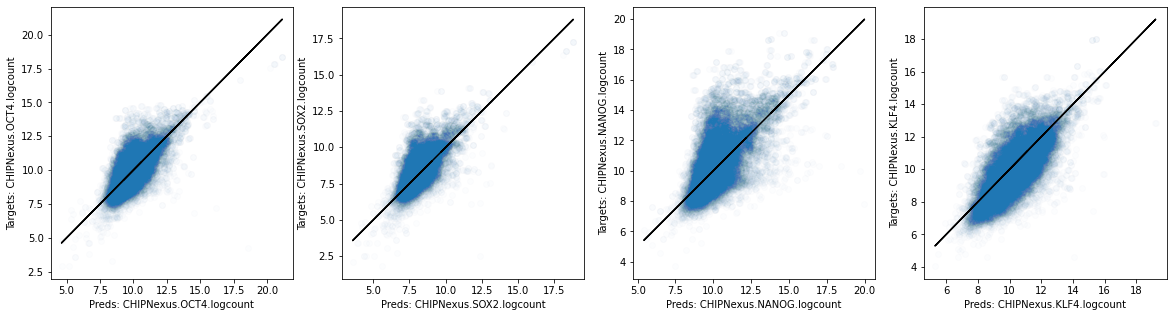

1614/1614 [==============================] - 714s 442ms/step - loss: 1934.4260 - CHIPNexus.NANOG.logcount_loss: 0.2467 - CHIPNexus.OCT4.logcount_loss: 0.1305 - CHIPNexus.KLF4.logcount_loss: 0.1977 - CHIPNexus.SOX2.logcount_loss: 0.0929 - CHIPNexus.NANOG.profile_loss: 1033.1604 - CHIPNexus.OCT4.profile_loss: 818.0164 - CHIPNexus.KLF4.profile_loss: 892.8422 - CHIPNexus.SOX2.profile_loss: 456.9871 - val_loss: 1749.2717 - val_CHIPNexus.NANOG.logcount_loss: 0.5484 - val_CHIPNexus.OCT4.logcount_loss: 0.2206 - val_CHIPNexus.KLF4.logcount_loss: 0.3445 - val_CHIPNexus.SOX2.logcount_loss: 0.1728 - val_CHIPNexus.NANOG.profile_loss: 1110.0114 - val_CHIPNexus.OCT4.profile_loss: 861.3273 - val_CHIPNexus.KLF4.profile_loss: 931.9034 - val_CHIPNexus.SOX2.profile_loss: 490.3121


In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

counts_loss, log_space_preds, c_task_weight = ("mse", True, 500)
#counts_loss, log_space_preds, c_task_weight = (poisson_loglinear_loss, True, 1)
modelwrapper = BPnetArch(
    counts_loss=counts_loss,
    log_space_preds=log_space_preds,
    input_seq_len=seq_len,
    counts_hiddenlayer_size=100,
    c_task_weight=c_task_weight,
    filters=64, n_dil_layers=6,
    conv1_kernel_size=21,
    dil_kernel_size=3,
    outconv_kernel_size=75,
    lr=0.001)


class PlotScatter(keras.callbacks.Callback):
    
    def __init__(self, takelogofpreds):
        self.takelogofpreds = takelogofpreds
    
    def on_epoch_begin(self, epoch, logs=None):
        print("Scatterplots before epoch",epoch)
        valid_preds = dict(zip(model.output_names, model.predict(valid_concat_inputs)))
        plot_scatter(preds=valid_preds, targets=valid_concat_targets,
                     takelogofpreds=self.takelogofpreds,
                     keys=['CHIPNexus.OCT4.logcount', 'CHIPNexus.SOX2.logcount',
                           'CHIPNexus.NANOG.logcount', 'CHIPNexus.KLF4.logcount'])

model = modelwrapper.get_keras_model()
print(model.summary())
early_stopping_callback = keras.callbacks.EarlyStopping(
                            patience=10, restore_best_weights=True)
loss_history = model.fit_generator(
                    keras_train_batch_generator,
                    epochs=200,
                    validation_data=keras_valid_batch_generator,
                    callbacks=[early_stopping_callback,
                               PlotScatter(takelogofpreds=(log_space_preds==False))],
                    workers=1)
model.set_weights(early_stopping_callback.best_weights)

In [12]:
model.save("withmseloss_countshiddenlayer100_model1.h5")
#model.save("withmseloss_model1.h5")

In [ ]:
!du -h withlogpoissonloss_model1.h5